In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [2]:
house = pd.read_csv("Bengaluru_House_Data.csv")
house.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
house.isnull().sum()
print(house.shape)
house.dtypes

(13320, 9)


area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

In [4]:
house.groupby('area_type')['area_type'].agg('count')


area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
#data cleaning
house = house.drop(['availability' , "area_type"  , "society"] , axis = 1)
house = house.dropna()
print(house.shape)
house.head()

(12710, 6)


,location,size,total_sqft,bath,balcony,price
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [6]:
house = house.rename(columns= {'size' : 'bhk'})
house['bhk'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '3 Bedroom', '1 BHK', '1 RK',
       '4 BHK', '1 Bedroom', '2 Bedroom', '6 Bedroom', '8 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '11 Bedroom', '43 Bedroom',
       '14 BHK', '8 BHK', '12 Bedroom', '10 Bedroom', '13 BHK'],
      dtype=object)

In [7]:
house['bhk'] = house['bhk'].apply(lambda size : int(size.split()[0]) )  
house['bhk'].unique()


array([ 2,  4,  3,  1,  6,  8,  7,  5, 11,  9, 27, 43, 14, 12, 10, 13],
      dtype=int64)

In [8]:
house.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [9]:
def convert_to_float(x):
    try:
        return float(x);
    except:
        try:
            range = x.split(" - ") ;
            return (  (int( range[0] ) + int(range[1] )) / 2) 
        except:
            return None

In [10]:
house.total_sqft  =  house.total_sqft.apply(lambda x : convert_to_float(x))


In [11]:
house = house.drop(  house[  ( house.bhk > 20 ) | (house.total_sqft == 0)  ].index     )


In [12]:
house["price_per_sqft"] = house["price"] * 100000 / house["total_sqft"]
house.head()

,location,bhk,total_sqft,bath,balcony,price,price_per_sqft
0,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,3699.810606
1,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,4615.384615
2,Uttarahalli,3,1440.0,2.0,3.0,62.00,4305.555556
3,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,6245.890861
4,Kothanur,2,1200.0,2.0,1.0,51.00,4250.000000


In [13]:
house.location = house.location.apply(lambda x :x.strip())
len(house.location.unique())

1253

In [14]:
len(house.location)

12708

In [15]:
location_stats = house.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               515
Sarjapur  Road           372
Electronic City          302
Kanakpura Road           261
Thanisandra              234
                        ... 
Kanakapura Main Road       1
Kanakapura Road            1
Kanakapura Road,           1
Kanakapura main  Road      1
whitefiled                 1
Name: location, Length: 1253, dtype: int64

In [16]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
len(location_stats_less_than_10 )

1016

In [17]:
house.location = house.location.apply(lambda x : 'other' if x in location_stats[location_stats <= 10] else x  )
len(house.location.unique())

238

In [18]:
# outlier removal => outlier are data points which will cause reduction in model


In [19]:
print(house.shape)
house = house[ ~( ( ( house["total_sqft"] / house["bhk"] ) < 100)  | ((house["total_sqft"] / house["bhk"] ) > 800))   ]
print(house.shape)

(12708, 7)
(11865, 7)


In [20]:

house.price_per_sqft.describe()


count     11820.000000
mean       6333.663641
std        4138.931268
min         500.000000
25%        4200.000000
50%        5263.157895
75%        6900.069735
max      176470.588235
Name: price_per_sqft, dtype: float64

In [21]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    
    
    for key,subdf in df.groupby('location'):
        mean  = np.mean(subdf.price_per_sqft)
        std_d = np.std(subdf.price_per_sqft)

        reduced_df = subdf[(subdf.price_per_sqft > (mean-std_d) ) &  (subdf.price_per_sqft <= (mean+std_d) )]
        df_out = pd.concat([df_out , reduced_df] , ignore_index = True)
        #print(df_out)

    return df_out


In [22]:

house = remove_pps_outliers(house)
house.shape

(9717, 7)

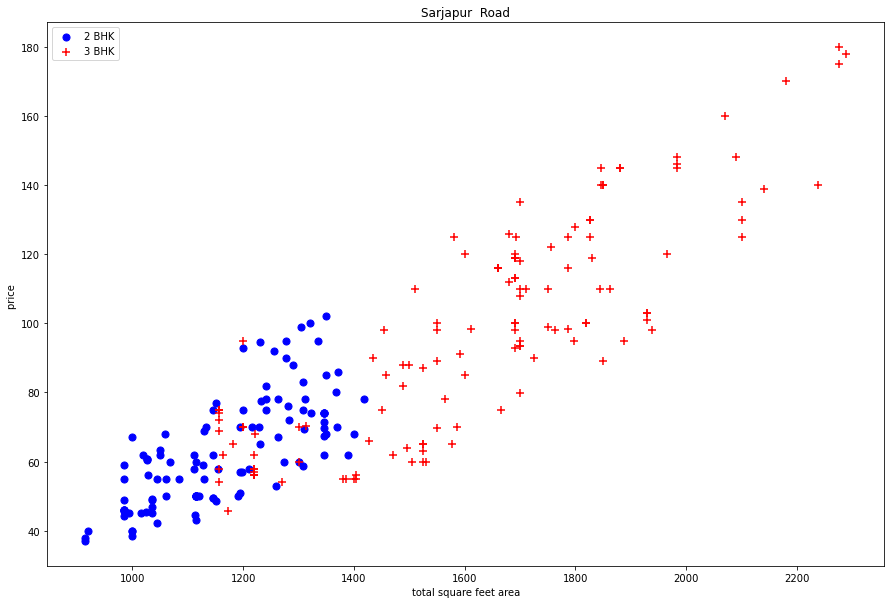

In [23]:
def plot_scatter_chart(df , location):
    bhk2 = df[ (df['location']  == location) & (df['bhk'] == 2 )]
    bhk3 = df[ (df['location']  == location) & (df['bhk'] == 3 )]

    matplotlib.rcParams['figure.figsize'] = (15 , 10)
    plt.scatter(bhk2.total_sqft , bhk2.price , color = 'blue' , label = '2 BHK'  , s=50)
    plt.scatter(bhk3.total_sqft , bhk3.price , color = 'red' , label = '3 BHK'  , s=50 , marker='+')

    
    plt.xlabel("total square feet area")
    plt.ylabel("price ")

    plt.title(location)
    plt.legend()
# plot_scatter_chart(house , 'Whitefield')
plot_scatter_chart(house , 'Sarjapur  Road') # Whitefield Sarjapur  Road    Sarjapur  Road  

In [24]:
#we should remove properties where for same location the price of 3 bedrooms apartment is less than 2 bedroom apartment 
#we will do is for a given location we will build  dictionary of stats per bhk .i.e.
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location,location_df in df.groupby('location') :
        bhk_stats = {}

        for bhk,bhk_df in location_df.groupby('bhk'):

            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df.price_per_sqft),
                'std' : np.std(bhk_df.price_per_sqft),
                'count' : bhk_df.shape[0],
            }
        
        for bhk,bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices =np.append(exclude_indices ,bhk_df[ bhk_df.price_per_sqft < (stats['mean']) ].index.values)
    return df.drop(exclude_indices , axis = 'index')
# now remove those 2 bhk apartment whose price_per_sqft in less than mean price_per_sqft of 1bhk aprtment


(6880, 7)


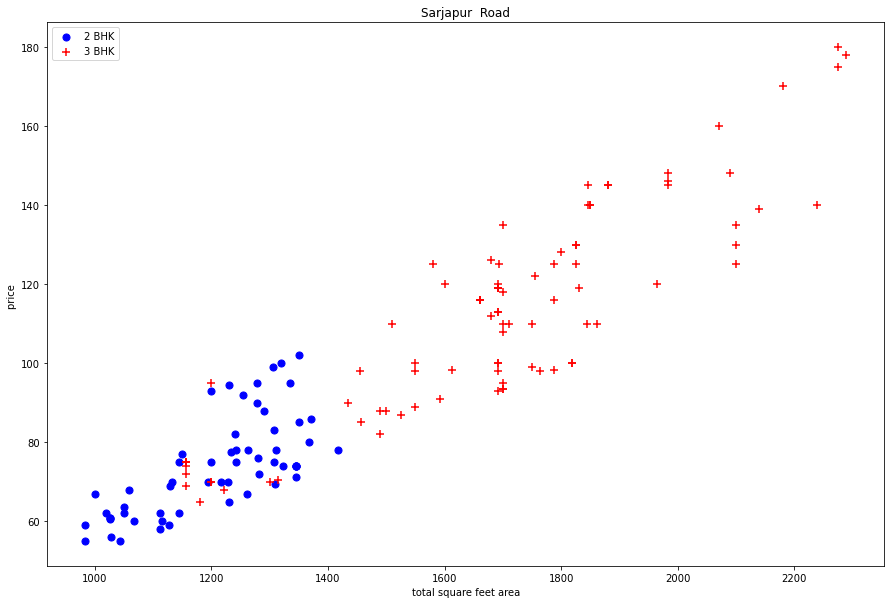

In [25]:
house = remove_bhk_outliers(house)
plot_scatter_chart(house , 'Sarjapur  Road')
print(house.shape)

Text(0, 0.5, 'count')

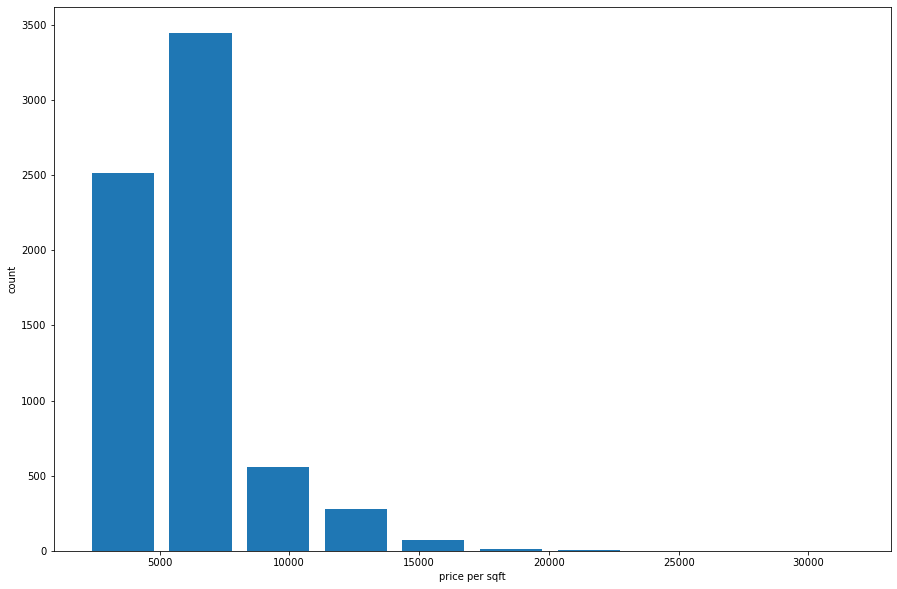

In [26]:
plt.hist(house.price_per_sqft , rwidth=0.8)
plt.xlabel("price per sqft")
plt.ylabel("count")

In [27]:
house.bath.unique()
house = house[ house['bath'] < (house['bhk'] + 2 ) ]
house.shape
house.bath.unique()


array([ 4.,  3.,  6.,  2.,  1.,  5.,  8.,  7.,  9., 10., 13.])

Text(0, 0.5, 'count')

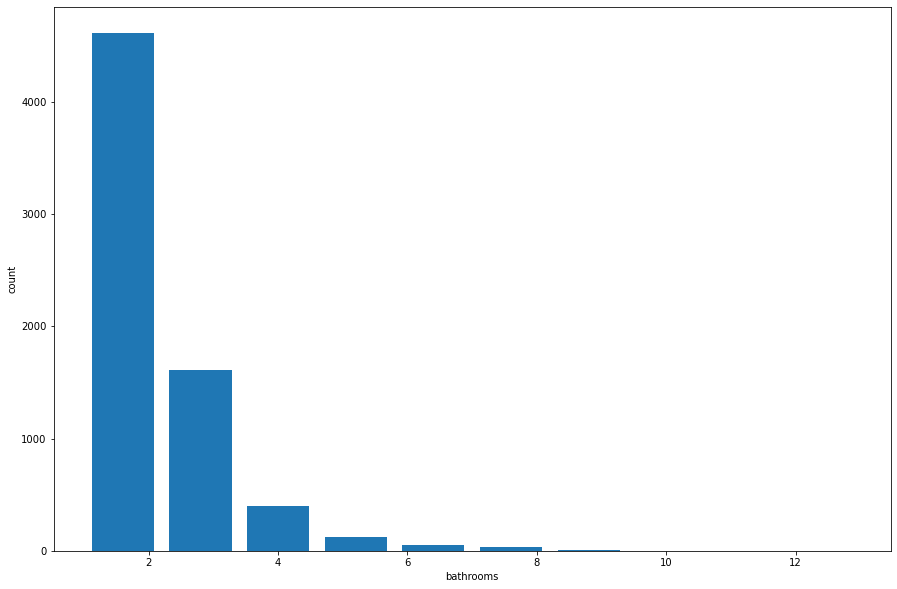

In [28]:
plt.hist(house.bath , rwidth=0.8)
plt.xlabel("bathrooms")
plt.ylabel("count")

In [29]:
house  = house.drop(['price_per_sqft' , 'balcony'] , axis= 1)
house.head()
house.shape

(6842, 5)

In [30]:
dummies = pd.get_dummies(house.location)
print(dummies.shape)
dummies.head()

(6842, 238)


,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
house = pd.concat(  [ house.drop( ['location'] , axis = 1) , dummies.drop(['other'] , axis = 1 ) ], axis = 'columns' )
house.head(2)

,bhk,total_sqft,bath,price,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,4,2850.0,4.0,428.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,1630.0,3.0,194.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
house.to_csv("my_clean_data.csv" , index = False)